In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
file_dir = os.listdir('Data/')
file_dir.sort()

# Stores strings of participants' IDs and pandas Dataframe objects
files = []
file_names = []
participant_id = []

for file_name in file_dir:
    usecols = ['trial', 'choice1', 'state', 'choice2', 'won']
    file = pd.read_csv('Data/' + file_name, sep='\t', index_col=0, usecols=usecols, skiprows=lambda x: x in range(3, 11)) # Start analysis at row 10
    
    file = file[file['choice1'] != 0] # Exclude trails that choice1 was missed
    file = file[file['choice2'] != 0] # Exclude trails that choice2 was missed
    file = file.dropna()
    
    files.append(file)
    file_names.append(file_name)
    participant_id.append(file_name[2:7])
    
# Drop 21st participant (106). Bad data: only picked first spaceship
files.pop(21)
file_names.pop(21)
participant_id.pop(21)
    
print(len(files))
for name in file_names:
    print(name)
print(participant_id)

30
SC00001_11-Apr-2019.txt
SC00002_26-Apr-2019.txt
SC00003_18-Jun-2019.txt
SC00004_13-May-2019.txt
SC00006_05-Aug-2019.txt
SC00007_28-Jun-2019.txt
SC00008_19-Jun-2019.txt
SC00009_24-Jun-2019.txt
SC00010_24-Jun-2019.txt
SC00012_19-Jul-2019.txt
SC00013_19-Jul-2019.txt
SC00014_02-Aug-2019.txt
SC00015_29-Jul-2019.txt
SC00016_30-Jul-2019.txt
SC00017_24-Jul-2019.txt
SC00020_23-Jul-2019.txt
SC00021_24-Jul-2019.txt
SC00022_27-Aug-2019.txt
SC00023_06-Sep-2019.txt
SC00024_27-Aug-2019.txt
SC00104_27-Sep-2018.txt
SC00108_12-Dec-2018.txt
SC00110_12-Dec-2018.txt
SC00111_12-Dec-2018.txt
SC00112_14-Sep-2019.txt
SC00113_14-Sep-2019.txt
SC00114_29-Mar-2019.txt
SC00115_01-Apr-2019.txt
SC00120_14-May-2019.txt
SC00121_14-May-2019.txt
['00001', '00002', '00003', '00004', '00006', '00007', '00008', '00009', '00010', '00012', '00013', '00014', '00015', '00016', '00017', '00020', '00021', '00022', '00023', '00024', '00104', '00108', '00110', '00111', '00112', '00113', '00114', '00115', '00120', '00121']


In [3]:
# Returns two arrays, each of size 2 [reward, no reward], of stay probability for common and rare transition
def get_analysis(file):
    
    # Stores stay probabilities: [reward, no reward]
    common = np.array([0, 0])
    rare = np.array([0, 0])
    
    # Stores total counts for normalization
    common_total = np.array([0, 0])
    rare_total = np.array([0, 0])
    
    for i in range(1, len(file)):
        prev_row = file.iloc[i - 1]
        row = file.iloc[i]
        
        # Index to access correct location of common/rare array for respective reward/no reward index
        reward_idx = 0 if prev_row['won'] else 1
        
        choice1 = prev_row['choice1'] == 1
        choice2 = ~choice1
        state2 = prev_row['state'] == 2
        state3 = ~state2
        
        # Common Transition
        if (choice1 and state2) or (choice2 and state3):
            common_total[reward_idx] += 1
            if prev_row['choice1'] == row['choice1']:
                # Stayed
                common[reward_idx] += 1
        # Rare Transition
        else:
            rare_total[reward_idx] += 1
            if prev_row['choice1'] == row['choice1']:
                # Stayed
                rare[reward_idx] += 1
    
    # Normalize
    common = common / common_total
    rare = rare / rare_total
    
    return common, rare

In [4]:
# Labels bar graph
def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('%.3f' % (height * 100),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

In [5]:
# Load betas for each participant
betas_file = pd.read_excel('Participant_Betas.xlsx', index_col=0)
betas_file.head()

,Age,MB_Betas,MF_Betas
1,74,0.016532,0.537988
2,75,0.159675,2.089894
3,67,0.892488,1.391852
4,70,0.720988,2.503806
6,80,0.995213,2.768572


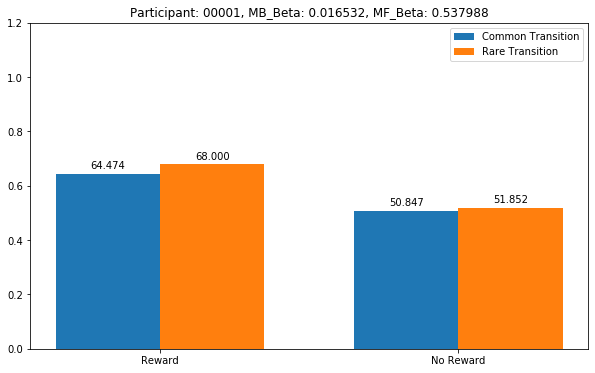

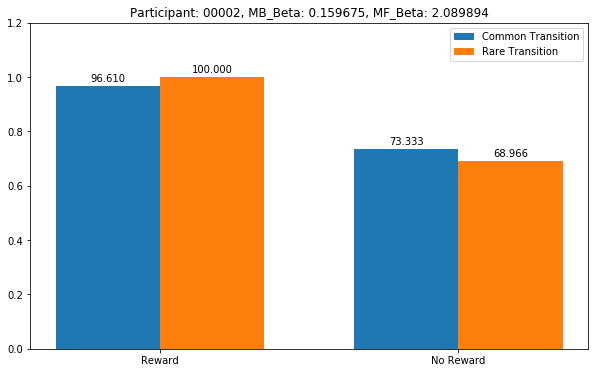

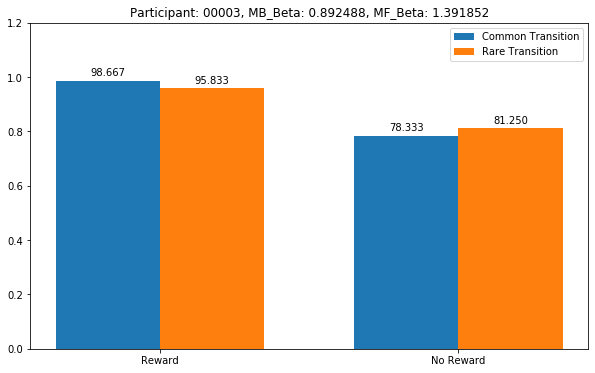

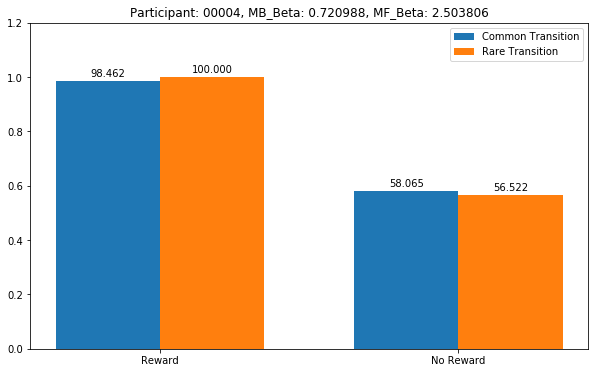

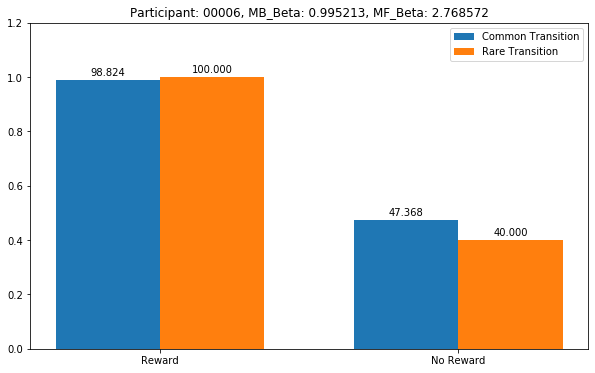

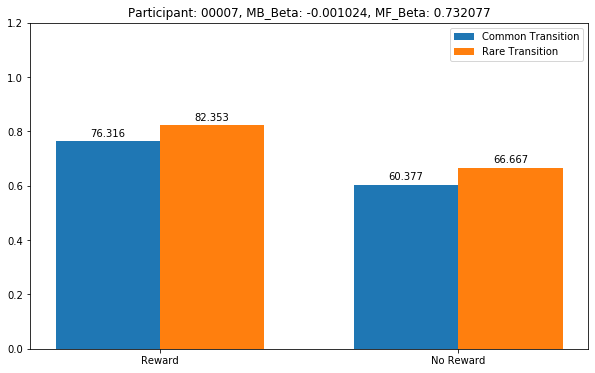

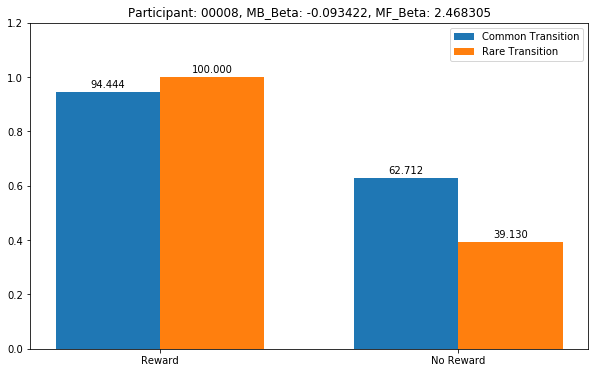

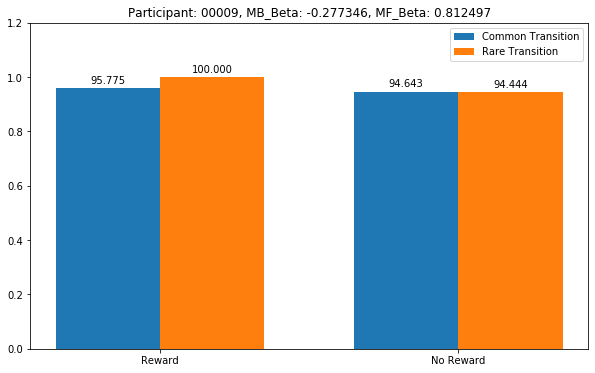

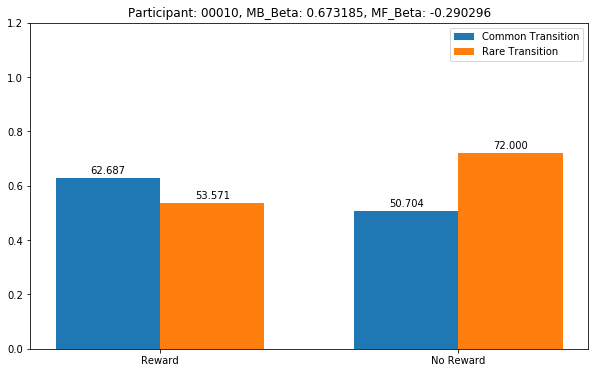

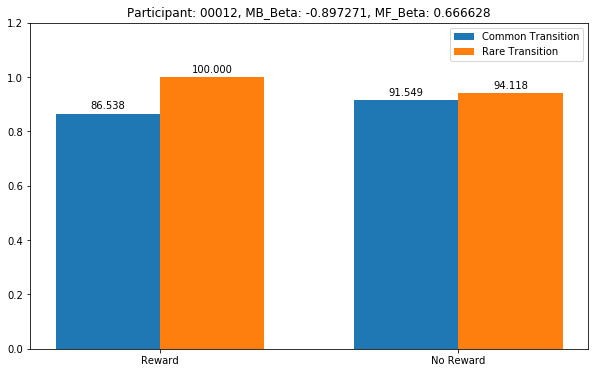

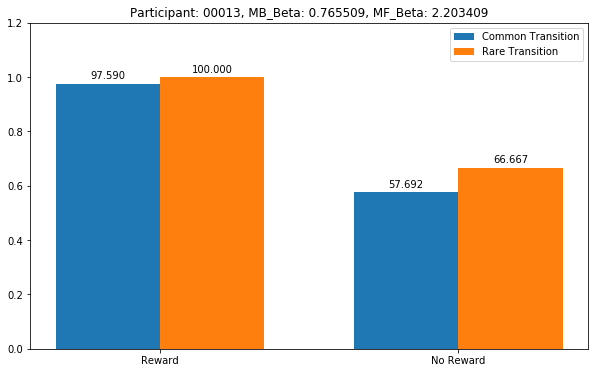

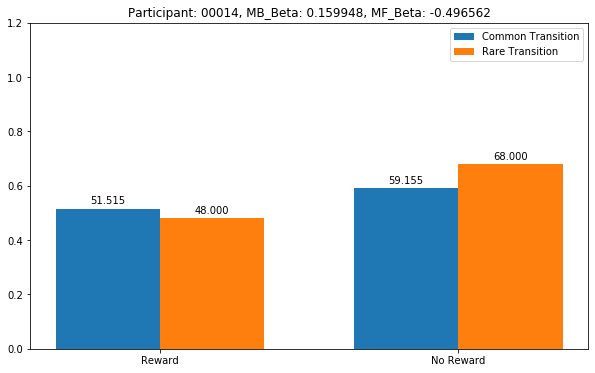

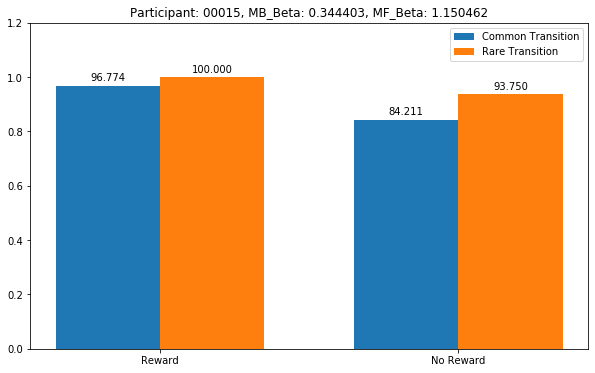

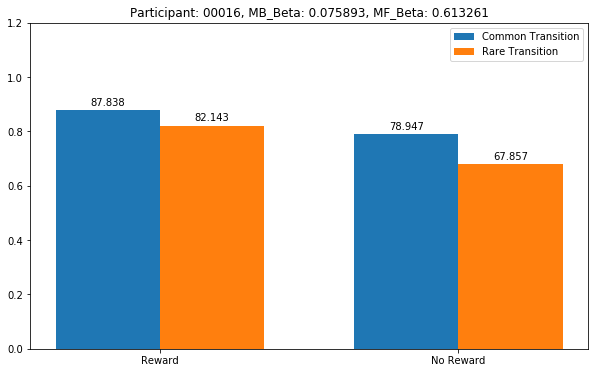

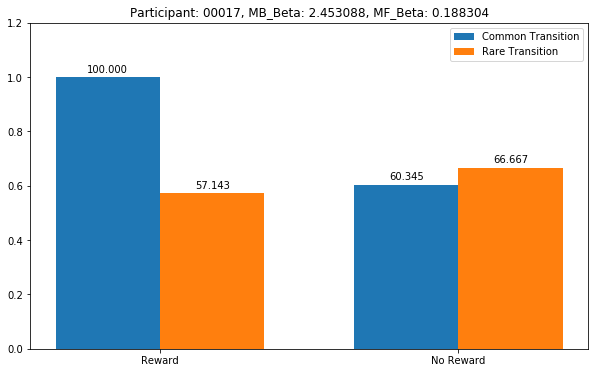

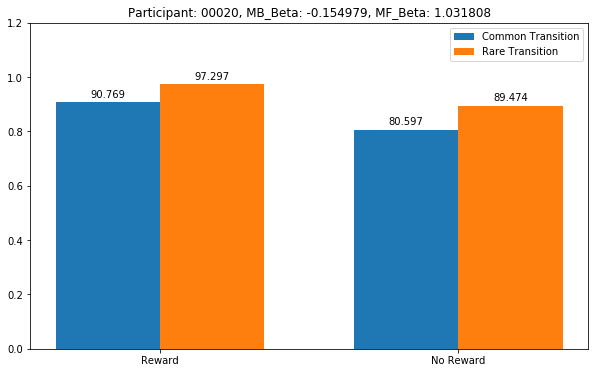

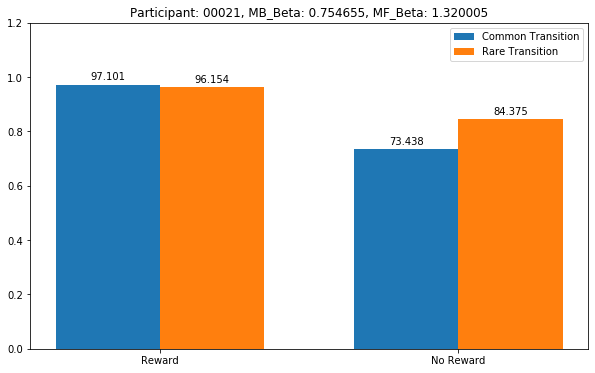

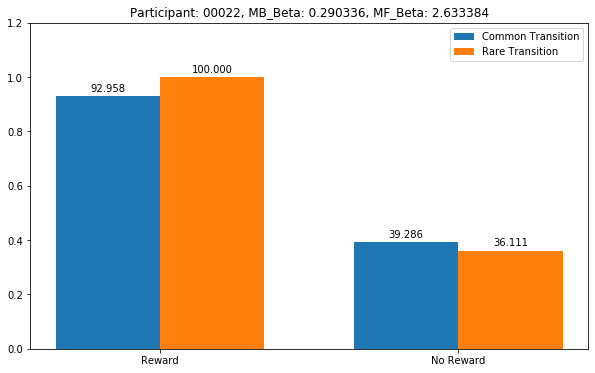

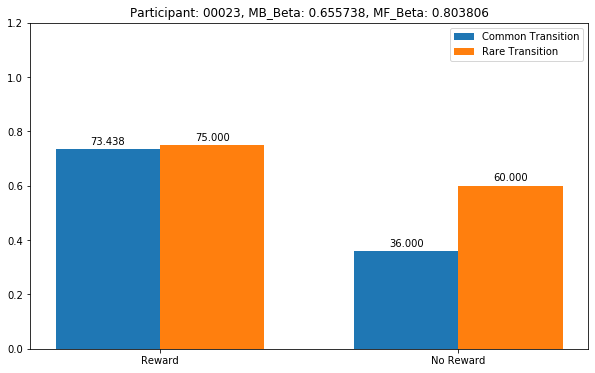

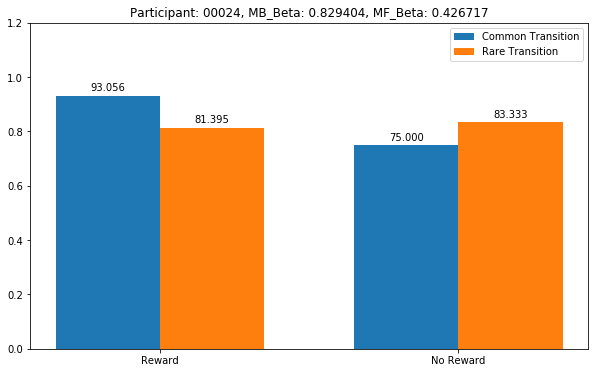

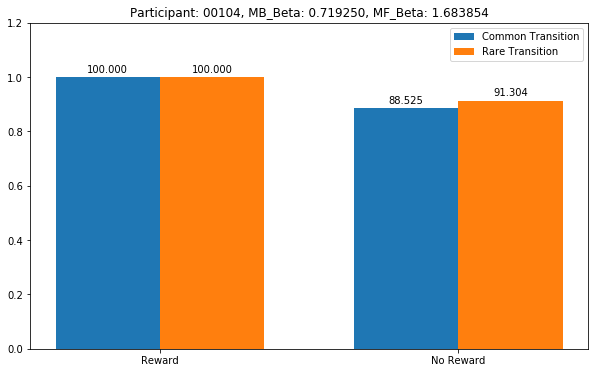

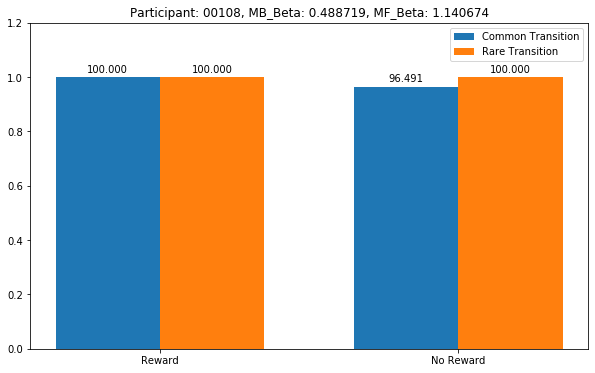

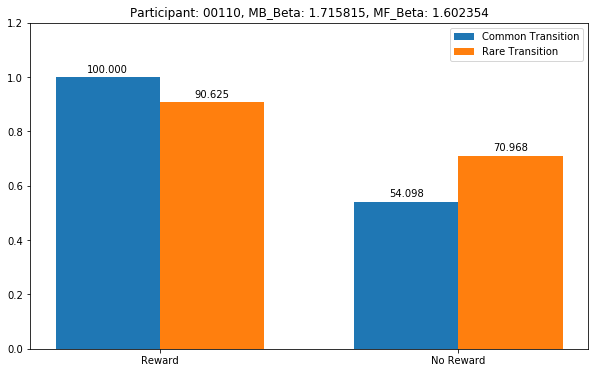

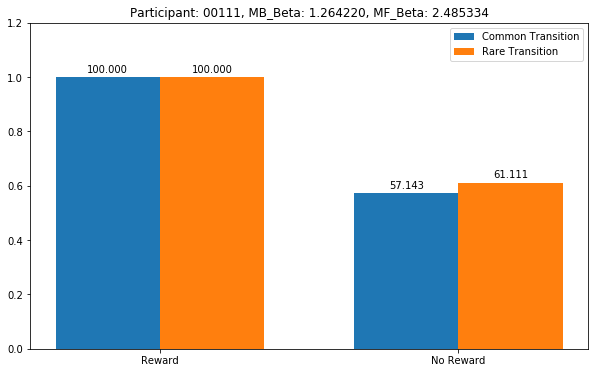

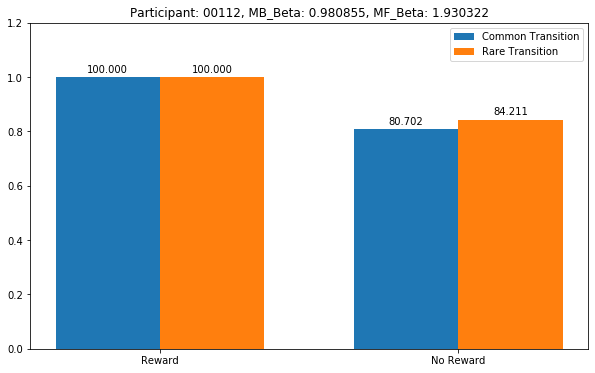

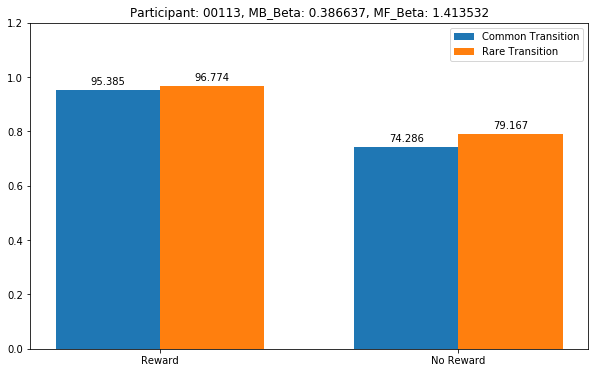

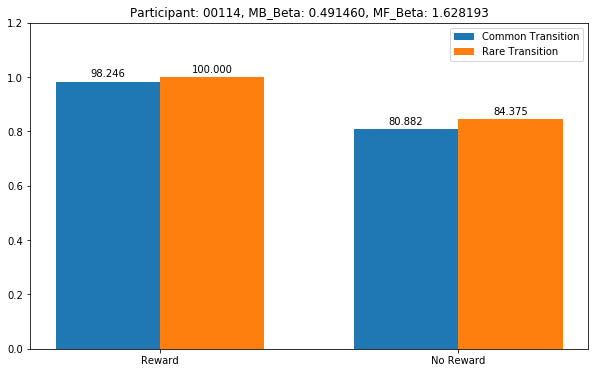

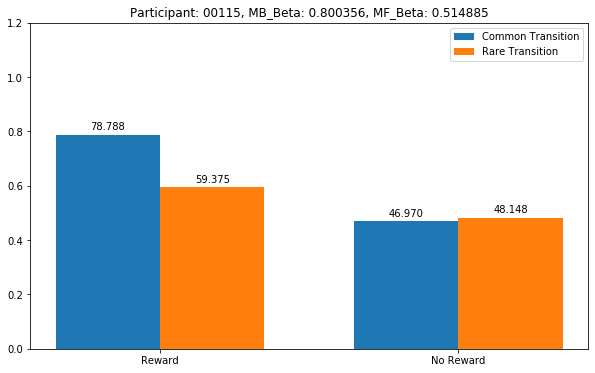

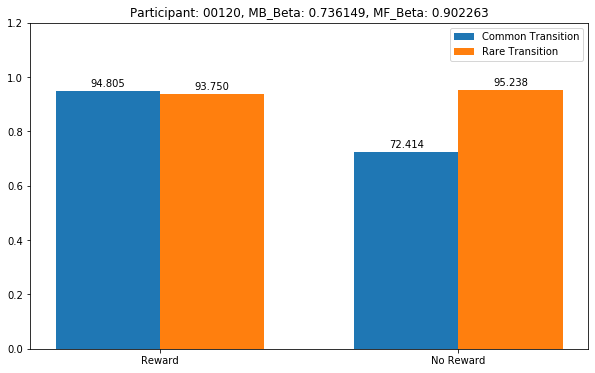

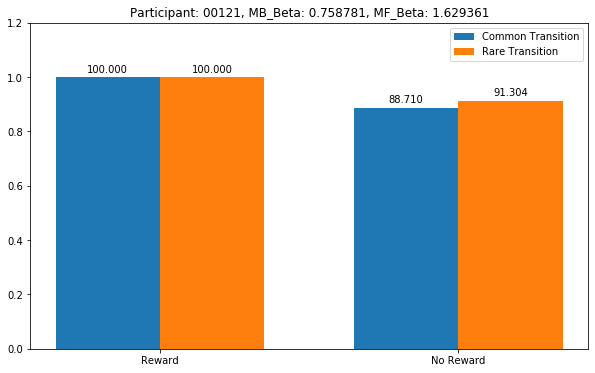

In [6]:
# Plot graph for each file
for file, p_id in zip(files, participant_id):
    common, rare = get_analysis(file)
    mb_beta = betas_file.loc[int(p_id)]['MB_Betas']
    mf_beta = betas_file.loc[int(p_id)]['MF_Betas']

    labels = ['Reward', 'No Reward']
    x = np.arange(len(labels))

    width = 0.35

    fig, ax = plt.subplots(figsize=(10,6))

    rect1 = ax.bar(x - width / 2, common, width, label='Common Transition')
    rect2 = ax.bar(x + width / 2, rare, width, label='Rare Transition')

    autolabel(rect1)
    autolabel(rect2)

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim([0, 1.2])
    ax.set_title('Participant: %s, MB_Beta: %f, MF_Beta: %f' % (p_id, mb_beta, mf_beta))
    ax.legend()
    plt.show()
    
    input()